## TRABAJO PRÁCTICO: Análisis de Transacciones con Tarjetas de Crédito 

---
## CONFIGURACIÓN DEL ENTORNO Y LIBRERÍAS

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from delta.tables import DeltaTable

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

# Configurar estilo de visualizaciones
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" Librerías importadas correctamente")
print(f" Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

 Librerías importadas correctamente
 Fecha de análisis: 2025-11-23 14:54:06


In [0]:
# CREAR SESIÓN DE SPARK

spark = SparkSession.builder \
    .appName("TP_Analisis_Transacciones_Bancarias") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

print(" SPARK SESSION INICIADA")

 SPARK SESSION INICIADA


---
## Carga del Dataset

In [0]:

df_raw = spark.read.csv("/Volumes/workspace/transactions/transactions_volume/out.csv", header=True, sep=";", inferSchema=True)  

print(" DATOS CARGADOS CORRECTAMENTE")
print(f" Total de registros: {df_raw.count():,}")
print(f" Número de columnas: {len(df_raw.columns)}")

 DATOS CARGADOS CORRECTAMENTE
 Total de registros: 64,651
 Número de columnas: 9


### Vista Previa de los Datos

In [0]:
# Mostrar primeras 10 filas 
print(" PRIMERAS 10 TRANSACCIONES:")
display(df_raw.limit(10).toPandas())

 PRIMERAS 10 TRANSACCIONES:


NIF,NOMBRE,TARJETA,FECHA,HORA_HOST,COD_OPERACION,COD_OPE_DESC,IMPORTE,Nombre_comercio_y_actividad
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-02,01.37.00,400,CARGO POR FACTURACION DE TARJETAS DE CREDITO,-2414.090087890625,___
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-03,17.17.46,801,COMPRA,180.6699981689453,GREGORIO III ___RESTAURANTES RESTO
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-05,19.07.17,800,COMPRA,66.44999694824219,TONY ROMA S ___RESTAURANTES RESTO
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-07,10.12.08,910,REINTEGRO EN CAJERO PROPIO,300.0,___CAJEROS AUTOMATICOS
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-11,10.20.38,800,COMPRA,142.8699951171875,RESTAURANTE SOLCHAGA ___RESTAURANTES RESTO
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-13,19.28.55,910,REINTEGRO EN CAJERO PROPIO,300.0,___CAJEROS AUTOMATICOS
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-22,16.33.07,910,REINTEGRO EN CAJERO PROPIO,300.0,___CAJEROS AUTOMATICOS
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-01-31,14.36.31,910,REINTEGRO EN CAJERO PROPIO,300.0,___CAJEROS AUTOMATICOS
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-02-01,08.03.12,400,CARGO POR FACTURACION DE TARJETAS DE CREDITO,-1785.050048828125,___
010018076N,"MORAL SANTIN, JOSE ANTONIO",4506259003971390,2003-02-01,16.45.08,801,COMPRA,155.10000610351562,RESTAURANTE ENTREREINAS SL ___RESTAURANTES RESTO


In [0]:
# Ver estructura del DataFrame
print("\n ESQUEMA DEL DATASET:")
df_raw.printSchema()


 ESQUEMA DEL DATASET:
root
 |-- NIF: string (nullable = true)
 |-- NOMBRE: string (nullable = true)
 |-- TARJETA: long (nullable = true)
 |-- FECHA: date (nullable = true)
 |-- HORA_HOST: string (nullable = true)
 |-- COD_OPERACION: integer (nullable = true)
 |-- COD_OPE_DESC: string (nullable = true)
 |-- IMPORTE: double (nullable = true)
 |-- Nombre_comercio_y_actividad: string (nullable = true)



In [0]:
# Análisis de valores nulos por columna
print("\n ANÁLISIS DE VALORES NULOS:")

null_counts = df_raw.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df_raw.columns]
)
null_counts.show()


 ANÁLISIS DE VALORES NULOS:
+---+------+-------+-----+---------+-------------+------------+-------+---------------------------+
|NIF|NOMBRE|TARJETA|FECHA|HORA_HOST|COD_OPERACION|COD_OPE_DESC|IMPORTE|Nombre_comercio_y_actividad|
+---+------+-------+-----+---------+-------------+------------+-------+---------------------------+
|  0|     0|     63|   63|        0|           63|          37|     63|                          0|
+---+------+-------+-----+---------+-------------+------------+-------+---------------------------+



In [0]:
# Guardar métricas iniciales
registros_iniciales = df_raw.count()
columnas_iniciales = len(df_raw.columns)

print(f"\n MÉTRICAS INICIALES:")
print(f"   • Registros: {registros_iniciales:,}")
print(f"   • Columnas: {columnas_iniciales}")


 MÉTRICAS INICIALES:
   • Registros: 64,651
   • Columnas: 9


---
## TRANSFORMACIÓN: LIMPIEZA Y PROCESAMIENTO DE DATOS

### Limpieza Básica

In [0]:
# ELIMINAR FILAS NULAS

df_limpio = df_raw.dropna(how='any')
filas_nulas = registros_iniciales - df_limpio.count()

print(f" Filas con Nulos eliminados: {filas_nulas}")

 Filas con Nulos eliminados: 100


In [0]:
# ELIMINAR DUPLICADOS

antes_duplicados = df_limpio.count()
df_limpio = df_limpio.dropDuplicates()
duplicados_eliminados = antes_duplicados - df_limpio.count()

print(f" Duplicados eliminados: {duplicados_eliminados}")

 Duplicados eliminados: 479


### Conversión de Tipos de Datos

In [0]:

# CONVERTIR HORA A FORMATO TIMESTAMP

# Limpiar formato de hora (de "01.37.00" a "01:37:00")
df_limpio = df_limpio.withColumn(
    "HORA_LIMPIA",
    regexp_replace(col("HORA_HOST"), "\\.", ":")
)

# Crear timestamp completo
df_limpio = df_limpio.withColumn(
    "TIMESTAMP_COMPLETO",
    to_timestamp(concat(col("FECHA"), lit(" "), col("HORA_LIMPIA")), "yyyy-MM-dd HH:mm:ss")
)

print(" Columnas HORA_LIMPIA y TIMESTAMP_COMPLETO creadas")

 Columnas HORA_LIMPIA y TIMESTAMP_COMPLETO creadas


### 🔧 Paso 3: Crear Columnas Calculadas

In [0]:

# COLUMNAS TEMPORALES

df_limpio = df_limpio \
    .withColumn("AÑO", year(col("FECHA"))) \
    .withColumn("MES", month(col("FECHA"))) \
    .withColumn("DIA", dayofmonth(col("FECHA"))) \
    .withColumn("DIA_SEMANA", dayofweek(col("FECHA"))) \
    .withColumn("NOMBRE_DIA", date_format(col("FECHA"), "EEEE")) \
    .withColumn("NOMBRE_MES", date_format(col("FECHA"), "MMMM")) \
    .withColumn("TRIMESTRE", quarter(col("FECHA")))

print(" Columnas temporales creadas: AÑO, MES, DIA, DIA_SEMANA, TRIMESTRE")

 Columnas temporales creadas: AÑO, MES, DIA, DIA_SEMANA, TRIMESTRE


In [0]:
# COLUMNA DE HORA 

df_limpio = df_limpio.withColumn(
    "HORA_NUMERO",
    hour(col("TIMESTAMP_COMPLETO"))
)

print("Columna HORA_NUMERO creada")

Columna HORA_NUMERO creada


In [0]:
# CATEGORIZAR RANGO HORARIO

df_limpio = df_limpio.withColumn(
    "RANGO_HORARIO",
    when((col("HORA_NUMERO") >= 6) & (col("HORA_NUMERO") < 12), "Mañana")
    .when((col("HORA_NUMERO") >= 12) & (col("HORA_NUMERO") < 18), "Tarde")
    .when((col("HORA_NUMERO") >= 18) & (col("HORA_NUMERO") < 24), "Noche")
    .otherwise("Madrugada")
)

print(" Columna RANGO_HORARIO creada (Mañana/Tarde/Noche/Madrugada)")

 Columna RANGO_HORARIO creada (Mañana/Tarde/Noche/Madrugada)


In [0]:
# IMPORTE ABSOLUTO Y CLASIFICACIÓN

df_limpio = df_limpio \
    .withColumn("IMPORTE_ABS", abs(col("IMPORTE"))) \
    .withColumn(
        "TIPO_TRANSACCION",
        when(col("IMPORTE") < 0, "CARGO")
        .when(col("IMPORTE") > 0, "GASTO")
        .otherwise("NEUTRO")
    )

print(" Columnas IMPORTE_ABS y TIPO_TRANSACCION creadas")

 Columnas IMPORTE_ABS y TIPO_TRANSACCION creadas


In [0]:

# EXTRAER CATEGORÍA Y NOMBRE DE COMERCIO 

# Dividir el campo en partes
df_limpio = df_limpio.withColumn(
    "array_parts",
    split(col("Nombre_comercio_y_actividad"), "___")
)

# Extraer categoría con validaciones múltiples
df_limpio = df_limpio.withColumn(
    "CATEGORIA_COMERCIO",
    when(
        (size(col("array_parts")) > 1) & 
        (length(trim(col("array_parts").getItem(1))) > 0),  # ← Verificar que NO esté vacía
        trim(col("array_parts").getItem(1))
    ).otherwise(lit("SIN CATEGORIA"))
)

# Extraer nombre del comercio
df_limpio = df_limpio.withColumn(
    "NOMBRE_COMERCIO",
    when(
        length(trim(col("array_parts").getItem(0))) > 0,
        trim(col("array_parts").getItem(0))
    ).otherwise(lit("COMERCIO DESCONOCIDO"))
)

# Limpiar columna temporal
df_limpio = df_limpio.drop("array_parts")

print(" Columnas CATEGORIA_COMERCIO y NOMBRE_COMERCIO creadas")
print("   - Categorías vacías → 'SIN CATEGORIA'")
print("   - Nombres vacíos → 'COMERCIO DESCONOCIDO'")


 Columnas CATEGORIA_COMERCIO y NOMBRE_COMERCIO creadas
   - Categorías vacías → 'SIN CATEGORIA'
   - Nombres vacíos → 'COMERCIO DESCONOCIDO'


In [0]:
# CLASIFICACIÓN DE MONTO

df_limpio = df_limpio.withColumn(
    "RANGO_GASTO",
    when(col("IMPORTE_ABS") < 50, "Bajo (<50€)")
    .when((col("IMPORTE_ABS") >= 50) & (col("IMPORTE_ABS") < 150), "Medio (50-150€)")
    .when((col("IMPORTE_ABS") >= 150) & (col("IMPORTE_ABS") < 300), "Alto (150-300€)")
    .otherwise("Muy Alto (>300€)")
)

print(" Columna RANGO_GASTO creada")

 Columna RANGO_GASTO creada


###  Resumen de Transformación

In [0]:
# Ver schema actualizado
print("\n ESQUEMA DESPUÉS DE TRANSFORMACIONES:")
df_limpio.printSchema()


 ESQUEMA DESPUÉS DE TRANSFORMACIONES:
root
 |-- NIF: string (nullable = true)
 |-- NOMBRE: string (nullable = true)
 |-- TARJETA: long (nullable = true)
 |-- FECHA: date (nullable = true)
 |-- HORA_HOST: string (nullable = true)
 |-- COD_OPERACION: integer (nullable = true)
 |-- COD_OPE_DESC: string (nullable = true)
 |-- IMPORTE: double (nullable = true)
 |-- Nombre_comercio_y_actividad: string (nullable = true)
 |-- HORA_LIMPIA: string (nullable = true)
 |-- TIMESTAMP_COMPLETO: timestamp (nullable = true)
 |-- AÑO: integer (nullable = true)
 |-- MES: integer (nullable = true)
 |-- DIA: integer (nullable = true)
 |-- DIA_SEMANA: integer (nullable = true)
 |-- NOMBRE_DIA: string (nullable = true)
 |-- NOMBRE_MES: string (nullable = true)
 |-- TRIMESTRE: integer (nullable = true)
 |-- HORA_NUMERO: integer (nullable = true)
 |-- RANGO_HORARIO: string (nullable = false)
 |-- IMPORTE_ABS: double (nullable = true)
 |-- TIPO_TRANSACCION: string (nullable = false)
 |-- CATEGORIA_COMERCIO: st

In [0]:
# Mostrar muestra de datos transformados
print("\n MUESTRA DE DATOS TRANSFORMADOS:")
print("="*70)
display(
    df_limpio.select(
        "FECHA", "HORA_NUMERO", "RANGO_HORARIO", "COD_OPE_DESC", 
        "IMPORTE", "TIPO_TRANSACCION", "CATEGORIA_COMERCIO"
    ).limit(10).toPandas()
)


 MUESTRA DE DATOS TRANSFORMADOS:


FECHA,HORA_NUMERO,RANGO_HORARIO,COD_OPE_DESC,IMPORTE,TIPO_TRANSACCION,CATEGORIA_COMERCIO
2004-11-03,15,Tarde,COMPRA,4.650000095367432,GASTO,AUTOPISTAS (TERMINALES)
2006-12-01,16,Tarde,COMPRA,5.400000095367432,GASTO,GARAJES Y APARCAMIENTOS
2011-09-28,9,Mañana,COMPRA,68.4000015258789,GASTO,C.A.M.P.S.A.
2004-03-06,1,Madrugada,COMPRA,91.77999877929688,GASTO,VIPS
2005-11-11,19,Noche,COMPRA,73.7300033569336,GASTO,GASOLINERAS
2009-09-22,23,Noche,REINTEGRO EN CAJERO PROPIO,600.0,GASTO,CAJEROS AUTOMATICOS
2009-04-27,12,Tarde,COMPRA,595.0,GASTO,CONFECCION TEXTIL EN GENERAL
2009-11-01,5,Madrugada,CARGO POR FACTURACION DE TARJETAS DE CREDITO,-2710.8798828125,CARGO,SIN CATEGORIA
2007-05-14,9,Mañana,COMPRA,40.0,GASTO,C.A.M.P.S.A.
2006-07-19,20,Noche,REINTEGRO EN CAJERO PROPIO,600.0,GASTO,CAJEROS AUTOMATICOS


In [0]:
# Calcular métricas finales
registros_finales = df_limpio.count()
registros_eliminados = registros_iniciales - registros_finales
porcentaje_eliminado = (registros_eliminados / registros_iniciales) * 100
columnas_finales = len(df_limpio.columns)
columnas_creadas = columnas_finales - columnas_iniciales

print("\n" + "="*70)
print(" RESUMEN DE TRANSFORMACIÓN")

print(f" Registros iniciales:     {registros_iniciales:,}")
print(f" Registros finales:       {registros_finales:,}")
print(f" Registros eliminados:    {registros_eliminados:,} ({porcentaje_eliminado:.2f}%)")
print(f" Columnas iniciales:      {columnas_iniciales}")
print(f" Columnas finales:        {columnas_finales}")
print(f" Columnas creadas:        {columnas_creadas}")


 RESUMEN DE TRANSFORMACIÓN
 Registros iniciales:     64,651
 Registros finales:       64,072
 Registros eliminados:    579 (0.90%)
 Columnas iniciales:      9
 Columnas finales:        25
 Columnas creadas:        16


---
## AGREGACIONES Y ANÁLISIS CON PYSPARK

In [0]:
# ANÁLISIS POR TIPO DE OPERACIÓN

print(" DISTRIBUCIÓN POR TIPO DE OPERACIÓN:")
df_limpio.groupBy("COD_OPE_DESC") \
    .agg(
        count("*").alias("Total_Transacciones"),
        round(sum("IMPORTE_ABS"), 2).alias("Importe_Total"),
        round(avg("IMPORTE_ABS"), 2).alias("Importe_Promedio")
    ) \
    .orderBy(col("Total_Transacciones").desc()) \
    .display()

 DISTRIBUCIÓN POR TIPO DE OPERACIÓN:


COD_OPE_DESC,Total_Transacciones,Importe_Total,Importe_Promedio
COMPRA,58953,6577027.06,111.56
CARGO POR FACTURACION DE TARJETAS DE CREDITO,3665,7119410.84,1942.54
REINTEGRO EN CAJERO PROPIO,999,485020.0,485.51
DEVOLUCION COMPRA (ABONO Y CARGO),312,45418.05,145.57
RECARGA TELEFONO GSM - CARGA EN FIRME,32,960.0,30.0
CHARGEBACK DE COMPRA (K915),29,6737.37,232.32
"ANUL.COMPRA,MARCAR/DESMARCAR FOTO(NMT)",26,3280.44,126.17
DEVOLUCION COMPRA,18,1902.1,105.67
DISPOSICION EFECTIVO OFICINA,12,18176.4,1514.7
REINTEGRO EN CAJERO AJENO NACIONAL,7,1971.44,281.63


In [0]:
# Analisis de gastos por año 
df_limpio_pd = df_limpio.toPandas()
evolucion_anual_pd = df_limpio_pd[df_limpio_pd["TIPO_TRANSACCION"] == "GASTO"].groupby("AÑO").agg(
    Transacciones=("IMPORTE", "count"),
    Total_Gastado=("IMPORTE", "sum"),
    Ticket_Promedio=("IMPORTE", "mean")
).reset_index().sort_values("AÑO")
print(" EVOLUCIÓN DE GASTOS POR AÑO:")

display(evolucion_anual_pd)

 EVOLUCIÓN DE GASTOS POR AÑO:


AÑO,Transacciones,Total_Gastado,Ticket_Promedio
2003,4804,547250.6396279335,113.91562023895368
2004,5193,492087.9301340468,94.75985560062523
2005,6058,611938.2799081504,101.01325188315458
2006,6639,730557.2200964391,110.04025005218243
2007,7274,874235.5000800937,120.18634864999915
2008,7442,962215.8400614634,129.29532922083627
2009,7060,879309.0398889035,124.54802264715347
2010,8228,993179.919894129,120.7073310517901
2011,7310,993926.4701186754,135.96805336780784


In [0]:


df_limpio_pd = df_limpio.toPandas()

# Gastos superiores a 500€ 
gastos_altos_pd = df_limpio_pd[
    (df_limpio_pd["IMPORTE"] > 500) & 
    (df_limpio_pd["TIPO_TRANSACCION"] == "GASTO")
]

total_gastos_altos = len(gastos_altos_pd)
monto_total_alto = gastos_altos_pd["IMPORTE"].sum()
porcentaje = (total_gastos_altos / len(df_limpio_pd[df_limpio_pd["IMPORTE"] > 0])) * 100

print(f"\n GASTOS SUPERIORES A 500€:")
print(f"   • Transacciones: {total_gastos_altos:,} ({porcentaje:.2f}% del total)")
print(f"   • Monto total: {monto_total_alto:,.2f}€")
print(f"   • Promedio por transacción: {monto_total_alto/total_gastos_altos:,.2f}€")

# Top categorías de gastos altos
print(f"\n CATEGORÍAS CON GASTOS >500€:")
top_categorias = gastos_altos_pd.groupby("CATEGORIA_COMERCIO").agg(
    Transacciones=("IMPORTE", "count"),
    Total_Gastado=("IMPORTE", "sum"),
    Ticket_Promedio=("IMPORTE", "mean")
).reset_index().sort_values("Total_Gastado", ascending=False).head(10)
display(top_categorias)

# Gastos extremos (>1000€)
print(f"\n GASTOS EXTREMOS (>1,000€):")
gastos_extremos_pd = df_limpio_pd[df_limpio_pd["IMPORTE"] > 1000]
print(f"   • Transacciones: {len(gastos_extremos_pd):,}")
print(f"   • Monto total: {gastos_extremos_pd['IMPORTE'].sum():,.2f}€")

# Muestra de gastos extremos
print(f"\n EJEMPLOS DE GASTOS EXTREMOS:")
ejemplos_extremos = gastos_extremos_pd[[
    "FECHA", "NOMBRE", "COD_OPE_DESC", "IMPORTE", 
    "NOMBRE_COMERCIO", "CATEGORIA_COMERCIO"
]].sort_values("IMPORTE", ascending=False).head(15)
display(ejemplos_extremos)


 GASTOS SUPERIORES A 500€:
   • Transacciones: 1,902 (3.17% del total)
   • Monto total: 1,817,929.89€
   • Promedio por transacción: 955.80€

 CATEGORÍAS CON GASTOS >500€:


CATEGORIA_COMERCIO,Transacciones,Total_Gastado,Ticket_Promedio
CAJEROS AUTOMATICOS,460,276000.0,600.0
AGENCIAS DE VIAJES,117,181398.56982421875,1550.4151267027244
RESTAURANTES RESTO,195,175223.15991210938,898.5803072415865
EL CORTE INGLES,138,171092.78979492188,1239.8028246008832
CONFECCION TEXTIL EN GENERAL,115,103344.66998291016,898.6493041992187
HIPERCOR SUPERMERCADOS EL CORTE INGLES,55,87185.61004638672,1585.192909934304
"HOTELES 4 Y 5 ESTRELLAS,BALNEARIOS,CAMPI",79,85235.91998291016,1078.9356959862046
"HOTELES,MOTELES,BALNEARIOS,CAMPINGS REST",54,57345.88018798828,1061.9607442220051
AUTOM.Y MOTOCICLETAS ( VENTAS Y REPARAC),42,45002.5500793457,1071.4892876034692
JOYERIAS Y RELOJERIAS,33,43888.75,1329.9621212121212



 GASTOS EXTREMOS (>1,000€):
   • Transacciones: 480
   • Monto total: 873,176.61€

 EJEMPLOS DE GASTOS EXTREMOS:


FECHA,NOMBRE,COD_OPE_DESC,IMPORTE,NOMBRE_COMERCIO,CATEGORIA_COMERCIO
2007-11-26,"ROMERO DE TEJADA Y PICATOSTE, RICARDO",DISPOSICION EFECTIVO OFICINA,11930.0,COMERCIO DESCONOCIDO,AGENCIAS BANCARIAS(ANTICIPO VENTANILLA)
2011-10-05,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,8000.0,EL CORTE INGLES,HIPERCOR SUPERMERCADOS EL CORTE INGLES
2010-12-14,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,5500.0,EL CORTE INGLES,HIPERCOR SUPERMERCADOS EL CORTE INGLES
2008-12-29,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,5500.0,VIAJES ECI,EL CORTE INGLES
2011-02-15,"CAFRANGA CAVESTANY, MARIA CARMEN",COMPRA,5500.0,"ICE TRAVEL SPAIN, S.L.",V.DIST.VIAJES Y TRANSPORTE DE VIAJEROS
2008-12-27,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,5500.0,VIAJES ECI,EL CORTE INGLES
2008-12-30,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,5266.02978515625,VIAJES ECI,EL CORTE INGLES
2009-12-28,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,5000.0,VIAJES ECI,EL CORTE INGLES
2008-12-16,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,5000.0,VIAJES ECI,EL CORTE INGLES
2009-12-19,"RODRIGUEZ-PONGA SALAMANCA, ESTANISLAO",COMPRA,5000.0,VIAJES ECI,EL CORTE INGLES


In [0]:
# TOP CATEGORÍAS DE COMERCIO

print("\n TOP 15 CATEGORÍAS DE COMERCIO:")
display(
    df_limpio.filter(col("CATEGORIA_COMERCIO").isNotNull() &  (col("IMPORTE") > 0))
    .groupBy("CATEGORIA_COMERCIO")
    .agg(
        count("*").alias("Num_Transacciones"),
        round(sum("IMPORTE"), 2).alias("Total_Gastado")
    )
    .orderBy(col("Num_Transacciones").desc())
    .limit(15)
    .toPandas()
)


 TOP 15 CATEGORÍAS DE COMERCIO:


CATEGORIA_COMERCIO,Num_Transacciones,Total_Gastado
RESTAURANTES RESTO,16454,1939216.22
GASOLINERAS,4974,259710.28
EL CORTE INGLES,3289,489738.6
C.A.M.P.S.A.,2836,159418.03
RESTAURANTES DE 4 Y 5 TENEDORES,2201,341862.64
"CAFETERIAS,SNACKS",1977,130246.27
GARAJES Y APARCAMIENTOS,1587,14435.63
HIPERCOR SUPERMERCADOS EL CORTE INGLES,1584,308599.55
"SUPERMERCADOS,ULTRAMARINOS, ECONOMATOS",1381,94981.25
TAXIS,1242,21612.86


In [0]:
# ANÁLISIS TEMPORAL: GASTOS POR MES

print("\n GASTOS POR MES:")
df_limpio_pd = df_limpio.toPandas()
gastos_mes = df_limpio_pd[df_limpio_pd["TIPO_TRANSACCION"] == "GASTO"].groupby(["AÑO", "MES"]).agg(
    Transacciones=("IMPORTE", "count"),
    Total_Gastado=("IMPORTE", "sum"),
    Promedio_Gasto=("IMPORTE", "mean")
).reset_index().sort_values(["AÑO", "MES"])
display(gastos_mes)


 GASTOS POR MES:


AÑO,MES,Transacciones,Total_Gastado,Promedio_Gasto
2003,1,380,49429.90986084938,130.07871016012996
2003,2,336,40667.33999347687,121.03374998058591
2003,3,413,49721.99010515213,120.39222785751122
2003,4,430,46367.15997123718,107.83060458427252
2003,5,372,42462.97984790802,114.14779529007532
2003,6,359,42185.2700316906,117.50771596571197
2003,7,420,43914.6699783802,104.55873804376239
2003,8,310,36458.699915885925,117.60870940608363
2003,9,397,46437.420083999634,116.9708314458429
2003,10,468,50054.23994612694,106.9535041583909


In [0]:
# PATRONES POR RANGO HORARIO

print("\n TRANSACCIONES POR RANGO HORARIO:")
df_limpio_pd = df_limpio.toPandas()
patrones_rango = df_limpio_pd.groupby("RANGO_HORARIO").agg(
    Total_Transacciones=("IMPORTE_ABS", "count"),
    Importe_Total=("IMPORTE_ABS", "sum")
).reset_index().sort_values("Total_Transacciones", ascending=False)
display(patrones_rango)


 TRANSACCIONES POR RANGO HORARIO:


RANGO_HORARIO,Total_Transacciones,Importe_Total
Tarde,39417,4423468.439484913
Noche,13049,1658278.519876305
Mañana,6037,2318877.0492394716
Madrugada,5569,5873979.919904351


In [0]:
# TOP COMERCIOS MÁS FRECUENTADOS

print("\n TOP 20 COMERCIOS MÁS FRECUENTADOS:")
df_limpio.filter(
    (col("NOMBRE_COMERCIO").isNotNull()) & 
    (col("NOMBRE_COMERCIO") != "") & 
    (col("IMPORTE") > 0)  
) \
    .groupBy("NOMBRE_COMERCIO", "CATEGORIA_COMERCIO") \
    .agg(
        count("*").alias("Visitas"),
        round(sum("IMPORTE"), 2).alias("Total_Gastado"),
        round(avg("IMPORTE"), 2).alias("Ticket_Promedio")
    ) \
    .orderBy(col("Visitas").desc()) \
    .show(20, truncate=False)


 TOP 20 COMERCIOS MÁS FRECUENTADOS:
+------------------------+----------------------------------------+-------+-------------+---------------+
|NOMBRE_COMERCIO         |CATEGORIA_COMERCIO                      |Visitas|Total_Gastado|Ticket_Promedio|
+------------------------+----------------------------------------+-------+-------------+---------------+
|EL CORTE INGLES         |EL CORTE INGLES                         |2589   |311719.43    |120.4          |
|COMERCIO DESCONOCIDO    |CAJEROS AUTOMATICOS                     |1036   |487351.44    |470.42         |
|EL CORTE INGLES         |HIPERCOR SUPERMERCADOS EL CORTE INGLES  |754    |180648.88    |239.59         |
|COMERCIO DESCONOCIDO    |RESTAURANTES RESTO                      |551    |63556.55     |115.35         |
|ASADOR CRUZ NEVADA      |RESTAURANTES RESTO                      |406    |13619.61     |33.55          |
|E.S.VEGONES DER         |C.A.M.P.S.A.                            |371    |20182.85     |54.4           |
|RENFE 00

In [0]:
print(f"\n ANALISIS DE GASTOS")
print(100*"-")

# Convertir a pandas y filtrar gastos
df_limpio_pd = df_limpio.toPandas()
gastos_por_persona_pd = df_limpio_pd[df_limpio_pd["IMPORTE"] > 0].groupby(["NIF", "NOMBRE"]).agg(
    Total_Transacciones=("IMPORTE", "count"),
    Total_Gastado=("IMPORTE", "sum"),
    Ticket_Promedio=("IMPORTE", "mean"),
    Primera_Transaccion=("FECHA", "min"),
    Ultima_Transaccion=("FECHA", "max")
).reset_index().sort_values("Total_Gastado", ascending=False)

# Top 5 gastadores
print(f"\n TOP 5 MAYORES GASTADORES:")
print(f"{'Posición':<10}{'Nombre':<35}{'Total Gastado':<18}{'Transacciones':<15}{'Promedio':<12}")


top_5 = gastos_por_persona_pd.head(5)
for i, row in enumerate(top_5.itertuples(index=False), 1):
    nombre = row.NOMBRE[:33]  # Truncar si es muy largo
    print(f"{i:<10}{nombre:<35}{row.Total_Gastado:>15,.2f}€  {row.Total_Transacciones:>12,}  {row.Ticket_Promedio:>10,.2f}€")

# Estadísticas generales
total_personas = gastos_por_persona_pd.shape[0]
gasto_total_general = df_limpio_pd[df_limpio_pd["IMPORTE"] > 0]["IMPORTE"].sum()
top_5_gasto = top_5["Total_Gastado"].sum()
porcentaje_top5 = (top_5_gasto / gasto_total_general) * 100

print(f"\n CONCENTRACIÓN DEL GASTO GENERAL:")
print(f"   • Total de personas: {total_personas}")
print(f"   • Gasto total del período: {gasto_total_general:,.2f}€")
print(f"   • Top 5 concentran: {top_5_gasto:,.2f}€ ({porcentaje_top5:.1f}% del total)")
print(f"   • Promedio por persona: {gasto_total_general/total_personas:,.2f}€")




 ANALISIS DE GASTOS
----------------------------------------------------------------------------------------------------

 TOP 5 MAYORES GASTADORES:
Posición  Nombre                             Total Gastado     Transacciones  Promedio    
1         MORAL SANTIN, JOSE ANTONIO              439,990.55€         1,197      367.58€
2         DE LA MERCED MONGE, MARIA MERCEDE       285,654.65€         1,596      178.98€
3         BAQUERO NORIEGA, FRANCISCO              265,111.32€         1,072      247.31€
4         ABEJAS JUAREZ, PABLO                    253,259.30€         1,711      148.02€
5         ROMERO LAZARO, ANTONIO                  246,704.99€         2,086      118.27€

 CONCENTRACIÓN DEL GASTO GENERAL:
   • Total de personas: 91
   • Gasto total del período: 7,084,700.84€
   • Top 5 concentran: 1,490,720.81€ (21.0% del total)
   • Promedio por persona: 77,853.86€


In [0]:

print(" COMPORTAMIENTO DURANTE LA CRISIS FINANCIERA 2008-2009")

# Definir períodos
pre_crisis = df_limpio.filter((col("AÑO") >= 2006) & (col("AÑO") <= 2007) & (col("IMPORTE") > 0))
en_crisis = df_limpio.filter((col("AÑO") >= 2008) & (col("AÑO") <= 2009) & (col("IMPORTE") > 0))
post_crisis = df_limpio.filter((col("AÑO") >= 2010) & (col("AÑO") <= 2011) & (col("IMPORTE") > 0))

# Calcular métricas
promedio_pre = pre_crisis.agg(avg("IMPORTE")).collect()[0][0]
promedio_crisis = en_crisis.agg(avg("IMPORTE")).collect()[0][0]
promedio_post = post_crisis.agg(avg("IMPORTE")).collect()[0][0]

total_pre = pre_crisis.agg(sum("IMPORTE")).collect()[0][0]
total_crisis = en_crisis.agg(sum("IMPORTE")).collect()[0][0]
total_post = post_crisis.agg(sum("IMPORTE")).collect()[0][0]

print(f"\n COMPARATIVA DE PERÍODOS:")
print(f"\n   PRE-CRISIS (2006-2007):")
print(f"      - Transacciones: {pre_crisis.count():,}")
print(f"      - Total gastado: {total_pre:,.2f}€")
print(f"      - Ticket promedio: {promedio_pre:.2f}€")

print(f"\n   EN PLENA CRISIS (2008-2009):")
print(f"      - Transacciones: {en_crisis.count():,}")
print(f"      - Total gastado: {total_crisis:,.2f}€")
print(f"      - Ticket promedio: {promedio_crisis:.2f}€")
print(f"      - Variación vs pre-crisis: {((promedio_crisis/promedio_pre)-1)*100:+.2f}%")

print(f"\n   POST-CRISIS (2010-2011):")
print(f"      - Transacciones: {post_crisis.count():,}")
print(f"      - Total gastado: {total_post:,.2f}€")
print(f"      - Ticket promedio: {promedio_post:.2f}€")

# Análisis de restaurantes de lujo durante crisis
print(f"\n GASTOS EN RESTAURANTES DURANTE LA CRISIS:")
restaurantes_crisis = en_crisis.filter(
    col("CATEGORIA_COMERCIO").contains("RESTAURANTE")
)
print(f"   - Comidas en restaurantes: {restaurantes_crisis.count():,}")
print(f"   - Total gastado: {restaurantes_crisis.agg(sum('IMPORTE')).collect()[0][0]:,.2f}€")
print(f"   - Ticket medio por comida: {restaurantes_crisis.agg(avg('IMPORTE')).collect()[0][0]:.2f}€")


 COMPORTAMIENTO DURANTE LA CRISIS FINANCIERA 2008-2009

 COMPARATIVA DE PERÍODOS:

   PRE-CRISIS (2006-2007):
      - Transacciones: 13,913
      - Total gastado: 1,604,792.72€
      - Ticket promedio: 115.34€

   EN PLENA CRISIS (2008-2009):
      - Transacciones: 14,502
      - Total gastado: 1,841,524.88€
      - Ticket promedio: 126.98€
      - Variación vs pre-crisis: +10.09%

   POST-CRISIS (2010-2011):
      - Transacciones: 15,538
      - Total gastado: 1,987,106.39€
      - Ticket promedio: 127.89€

 GASTOS EN RESTAURANTES DURANTE LA CRISIS:
   - Comidas en restaurantes: 4,704
   - Total gastado: 634,192.90€
   - Ticket medio por comida: 134.82€


---
## SPARK SQL: CONSULTAS CON SQL

In [0]:
# REGISTRAR DATAFRAME COMO VISTA TEMPORAL

df_limpio.createOrReplaceTempView("transacciones")
print(" Vista temporal 'transacciones' creada")

 Vista temporal 'transacciones' creada


In [0]:
# Resumen general

print(" RESUMEN GENERAL DEL DATASET")

spark.sql("""
    SELECT 
        COUNT(*) as Total_Transacciones,
        COUNT(DISTINCT NIF) as Clientes_Unicos,
        COUNT(DISTINCT TARJETA) as Tarjetas_Unicas,
        COUNT(DISTINCT CATEGORIA_COMERCIO) as Categorias_Unicas,
        ROUND(SUM(IMPORTE_ABS), 2) as Suma_Total_Importes,
        ROUND(AVG(IMPORTE_ABS), 2) as Importe_Promedio,
        MIN(FECHA) as Fecha_Inicial,
        MAX(FECHA) as Fecha_Final
    FROM transacciones
""").show(truncate=False)

 RESUMEN GENERAL DEL DATASET
+-------------------+---------------+---------------+-----------------+-------------------+----------------+-------------+-----------+
|Total_Transacciones|Clientes_Unicos|Tarjetas_Unicas|Categorias_Unicas|Suma_Total_Importes|Importe_Promedio|Fecha_Inicial|Fecha_Final|
+-------------------+---------------+---------------+-----------------+-------------------+----------------+-------------+-----------+
|64072              |64             |148            |372              |1.427460393E7      |222.79          |2003-01-01   |2012-01-01 |
+-------------------+---------------+---------------+-----------------+-------------------+----------------+-------------+-----------+



In [0]:
# Análisis de cajeros automáticos


print(" ANÁLISIS DE USO DE CAJEROS")

spark.sql("""
    SELECT 
        RANGO_HORARIO,
        COUNT(*) as Total_Retiros,
        ROUND(SUM(IMPORTE_ABS), 2) as Monto_Total_Retirado,
        ROUND(AVG(IMPORTE_ABS), 2) as Promedio_Por_Retiro
    FROM transacciones
    WHERE COD_OPE_DESC LIKE '%CAJERO%'
    GROUP BY RANGO_HORARIO
    ORDER BY Total_Retiros DESC
""").show()

 ANÁLISIS DE USO DE CAJEROS
+-------------+-------------+--------------------+-------------------+
|RANGO_HORARIO|Total_Retiros|Monto_Total_Retirado|Promedio_Por_Retiro|
+-------------+-------------+--------------------+-------------------+
|        Noche|          464|            242317.2|             522.24|
|        Tarde|          348|           156914.24|              450.9|
|       Mañana|          179|             79950.0|             446.65|
|    Madrugada|           15|              7810.0|             520.67|
+-------------+-------------+--------------------+-------------------+



In [0]:
# Top restaurantes por gasto

print("\n TOP 10 RESTAURANTES POR GASTO TOTAL")
print("="*70)

spark.sql("""
    SELECT 
        NOMBRE_COMERCIO,
        COUNT(*) as Num_Visitas,
        ROUND(SUM(IMPORTE), 2) as Total_Gastado,
        ROUND(AVG(IMPORTE), 2) as Ticket_Promedio
    FROM transacciones
    WHERE CATEGORIA_COMERCIO LIKE '%RESTAURANTE%'
        AND NOMBRE_COMERCIO IS NOT NULL
        AND NOMBRE_COMERCIO != ''
    GROUP BY NOMBRE_COMERCIO
    ORDER BY Total_Gastado DESC
    LIMIT 10
""").show(truncate=False)


 TOP 10 RESTAURANTES POR GASTO TOTAL
+-----------------------+-----------+-------------+---------------+
|NOMBRE_COMERCIO        |Num_Visitas|Total_Gastado|Ticket_Promedio|
+-----------------------+-----------+-------------+---------------+
|COMERCIO DESCONOCIDO   |555        |63894.69     |115.13         |
|RESTAURANTE CANTOBLANCO|49         |45345.61     |925.42         |
|RESTAURANTE ERROTA ZAR |179        |37418.04     |209.04         |
|REST EL ESPIGON        |219        |27162.52     |124.03         |
|ADOC GOURMET, S.A.     |89         |26671.37     |299.68         |
|REST. MOA#A            |129        |24051.52     |186.45         |
|CASA MUNDI             |149        |22740.83     |152.62         |
|EL BALCON              |38         |20260.0      |533.16         |
|REST AINOHA            |96         |18323.39     |190.87         |
|HOTEL R. CURRITO       |91         |17958.88     |197.35         |
+-----------------------+-----------+-------------+---------------+



In [0]:
# Gastos por día de la semana

print("\n PATRONES DE GASTO POR DÍA DE LA SEMANA")

spark.sql("""
    SELECT 
        CASE DIA_SEMANA
            WHEN 1 THEN 'Lunes'
            WHEN 2 THEN 'Martes'
            WHEN 3 THEN 'Miércoles'
            WHEN 4 THEN 'Jueves'
            WHEN 5 THEN 'Viernes'
            WHEN 6 THEN 'Sábado'
            WHEN 7 THEN 'Domingo'
            ELSE NOMBRE_DIA
        END AS DIA_ES,
        COUNT(*) as Total_Transacciones,
        ROUND(SUM(CASE WHEN TIPO_TRANSACCION = 'GASTO' THEN IMPORTE ELSE 0 END), 2) as Total_Gastado,
        ROUND(AVG(CASE WHEN TIPO_TRANSACCION = 'GASTO' THEN IMPORTE END), 2) as Gasto_Promedio
    FROM transacciones
    GROUP BY DIA_ES, DIA_SEMANA
    ORDER BY DIA_SEMANA
""").show()


 PATRONES DE GASTO POR DÍA DE LA SEMANA
+---------+-------------------+-------------+--------------+
|   DIA_ES|Total_Transacciones|Total_Gastado|Gasto_Promedio|
+---------+-------------------+-------------+--------------+
|    Lunes|               5862|    640401.75|        112.71|
|   Martes|               9364|   1010443.05|        122.66|
|Miércoles|              10757|    1148972.8|        113.27|
|   Jueves|               9801|   1055328.67|        114.77|
|  Viernes|               9402|   1054423.14|        119.08|
|   Sábado|              10096|   1140356.59|        121.11|
|  Domingo|               8790|   1034774.84|        122.05|
+---------+-------------------+-------------+--------------+



In [0]:

## Gastos de alto monto

print("\n GASTOS DE ALTO MONTO (>500€)")
print("="*70)

spark.sql("""
    SELECT 
        FECHA,
        COD_OPE_DESC,
        NOMBRE_COMERCIO,
        CATEGORIA_COMERCIO,
        ROUND(IMPORTE, 2) as Importe
    FROM transacciones
    WHERE IMPORTE > 500 AND TIPO_TRANSACCION = 'GASTO'
    ORDER BY IMPORTE DESC
    LIMIT 20
""").show(truncate=False)


 GASTOS DE ALTO MONTO (>500€)
+----------+----------------------------+----------------------+---------------------------------------+-------+
|FECHA     |COD_OPE_DESC                |NOMBRE_COMERCIO       |CATEGORIA_COMERCIO                     |Importe|
+----------+----------------------------+----------------------+---------------------------------------+-------+
|2007-11-26|DISPOSICION EFECTIVO OFICINA|COMERCIO DESCONOCIDO  |AGENCIAS BANCARIAS(ANTICIPO VENTANILLA)|11930.0|
|2011-10-05|COMPRA                      |EL CORTE INGLES       |HIPERCOR SUPERMERCADOS EL CORTE INGLES |8000.0 |
|2010-12-14|COMPRA                      |EL CORTE INGLES       |HIPERCOR SUPERMERCADOS EL CORTE INGLES |5500.0 |
|2011-02-15|COMPRA                      |ICE TRAVEL SPAIN, S.L.|V.DIST.VIAJES Y TRANSPORTE DE VIAJEROS |5500.0 |
|2008-12-27|COMPRA                      |VIAJES ECI            |EL CORTE INGLES                        |5500.0 |
|2008-12-29|COMPRA                      |VIAJES ECI            |E

---
## DELTA LAKE 

In [0]:
# Guardar DataFrame como Archivos Delta

print("GUARDANDO DATOS EN FORMATO DELTA")

# Ruta donde guardaremos los archivos Delta
delta_path = "/Volumes/workspace/transactions/transactions_volume/transacciones_delta"

# Guardar como archivos Delta
df_limpio.write.format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .save(delta_path)

print(f"Archivos Delta guardados en: {delta_path}")
print(f"Registros guardados: {df_limpio.count():,}")
print(f"Columnas guardadas: {len(df_limpio.columns)}")

# Verificar los archivos creados
print("\ncARCHIVOS CREADOS:")
dbutils.fs.ls(delta_path)

GUARDANDO DATOS EN FORMATO DELTA
Archivos Delta guardados en: /Volumes/workspace/transactions/transactions_volume/transacciones_delta
Registros guardados: 64,072
Columnas guardadas: 25

cARCHIVOS CREADOS:


[FileInfo(path='dbfs:/Volumes/workspace/transactions/transactions_volume/transacciones_delta/_delta_log/', name='_delta_log/', size=0, modificationTime=1763910018272),
 FileInfo(path='dbfs:/Volumes/workspace/transactions/transactions_volume/transacciones_delta/part-00000-2a81c88d-6e2d-4ee5-b973-592051d1681c.c000.snappy.parquet', name='part-00000-2a81c88d-6e2d-4ee5-b973-592051d1681c.c000.snappy.parquet', size=2992564, modificationTime=1763910017000),
 FileInfo(path='dbfs:/Volumes/workspace/transactions/transactions_volume/transacciones_delta/part-00000-65c93aac-5aff-4998-96de-73c34c8d4bb4.c000.snappy.parquet', name='part-00000-65c93aac-5aff-4998-96de-73c34c8d4bb4.c000.snappy.parquet', size=2992564, modificationTime=1763909745000)]

In [0]:
# LEER DESDE DELTA LAKE


df_desde_delta = spark.read \
    .format("delta") \
    .load(delta_path)

registros_delta = df_desde_delta.count()

print(f" Datos leídos desde Delta Lake")
print(f" Registros recuperados: {registros_delta:,}")


 Datos leídos desde Delta Lake
 Registros recuperados: 64,072


In [0]:
# VALIDAR INTEGRIDAD

print(f" Registros originales (df_limpio):  {registros_finales:,}")
print(f" Registros desde Delta Lake:        {registros_delta:,}")
print(f" Columnas originales:                {len(df_limpio.columns)}")
print(f" Columnas desde Delta:               {len(df_desde_delta.columns)}")

if registros_finales == registros_delta and len(df_limpio.columns) == len(df_desde_delta.columns):
    print("\n INTEGRIDAD VALIDADA: Los datos son consistentes")
else:
    print("\n ADVERTENCIA: Hay diferencias en los datos")

 Registros originales (df_limpio):  64,072
 Registros desde Delta Lake:        64,072
 Columnas originales:                25
 Columnas desde Delta:               25

 INTEGRIDAD VALIDADA: Los datos son consistentes


In [0]:
# Muestra de datos desde Delta

print("\n MUESTRA DE DATOS DESDE DELTA LAKE:")
df_desde_delta.select(
    "FECHA", "COD_OPE_DESC", "IMPORTE", "CATEGORIA_COMERCIO", "RANGO_HORARIO"
).show(10, truncate=False)




 MUESTRA DE DATOS DESDE DELTA LAKE:
+----------+--------------------------------------------+-----------------+----------------------------+-------------+
|FECHA     |COD_OPE_DESC                                |IMPORTE          |CATEGORIA_COMERCIO          |RANGO_HORARIO|
+----------+--------------------------------------------+-----------------+----------------------------+-------------+
|2004-11-03|COMPRA                                      |4.650000095367432|AUTOPISTAS (TERMINALES)     |Tarde        |
|2006-12-01|COMPRA                                      |5.400000095367432|GARAJES Y APARCAMIENTOS     |Tarde        |
|2011-09-28|COMPRA                                      |68.4000015258789 |C.A.M.P.S.A.                |Mañana       |
|2004-03-06|COMPRA                                      |91.77999877929688|VIPS                        |Madrugada    |
|2005-11-11|COMPRA                                      |73.7300033569336 |GASOLINERAS                 |Noche        |
|2009-09-22

---
## VISUALIZACIONES Y ANÁLISIS GRÁFICO

###  Gastos Mensuales

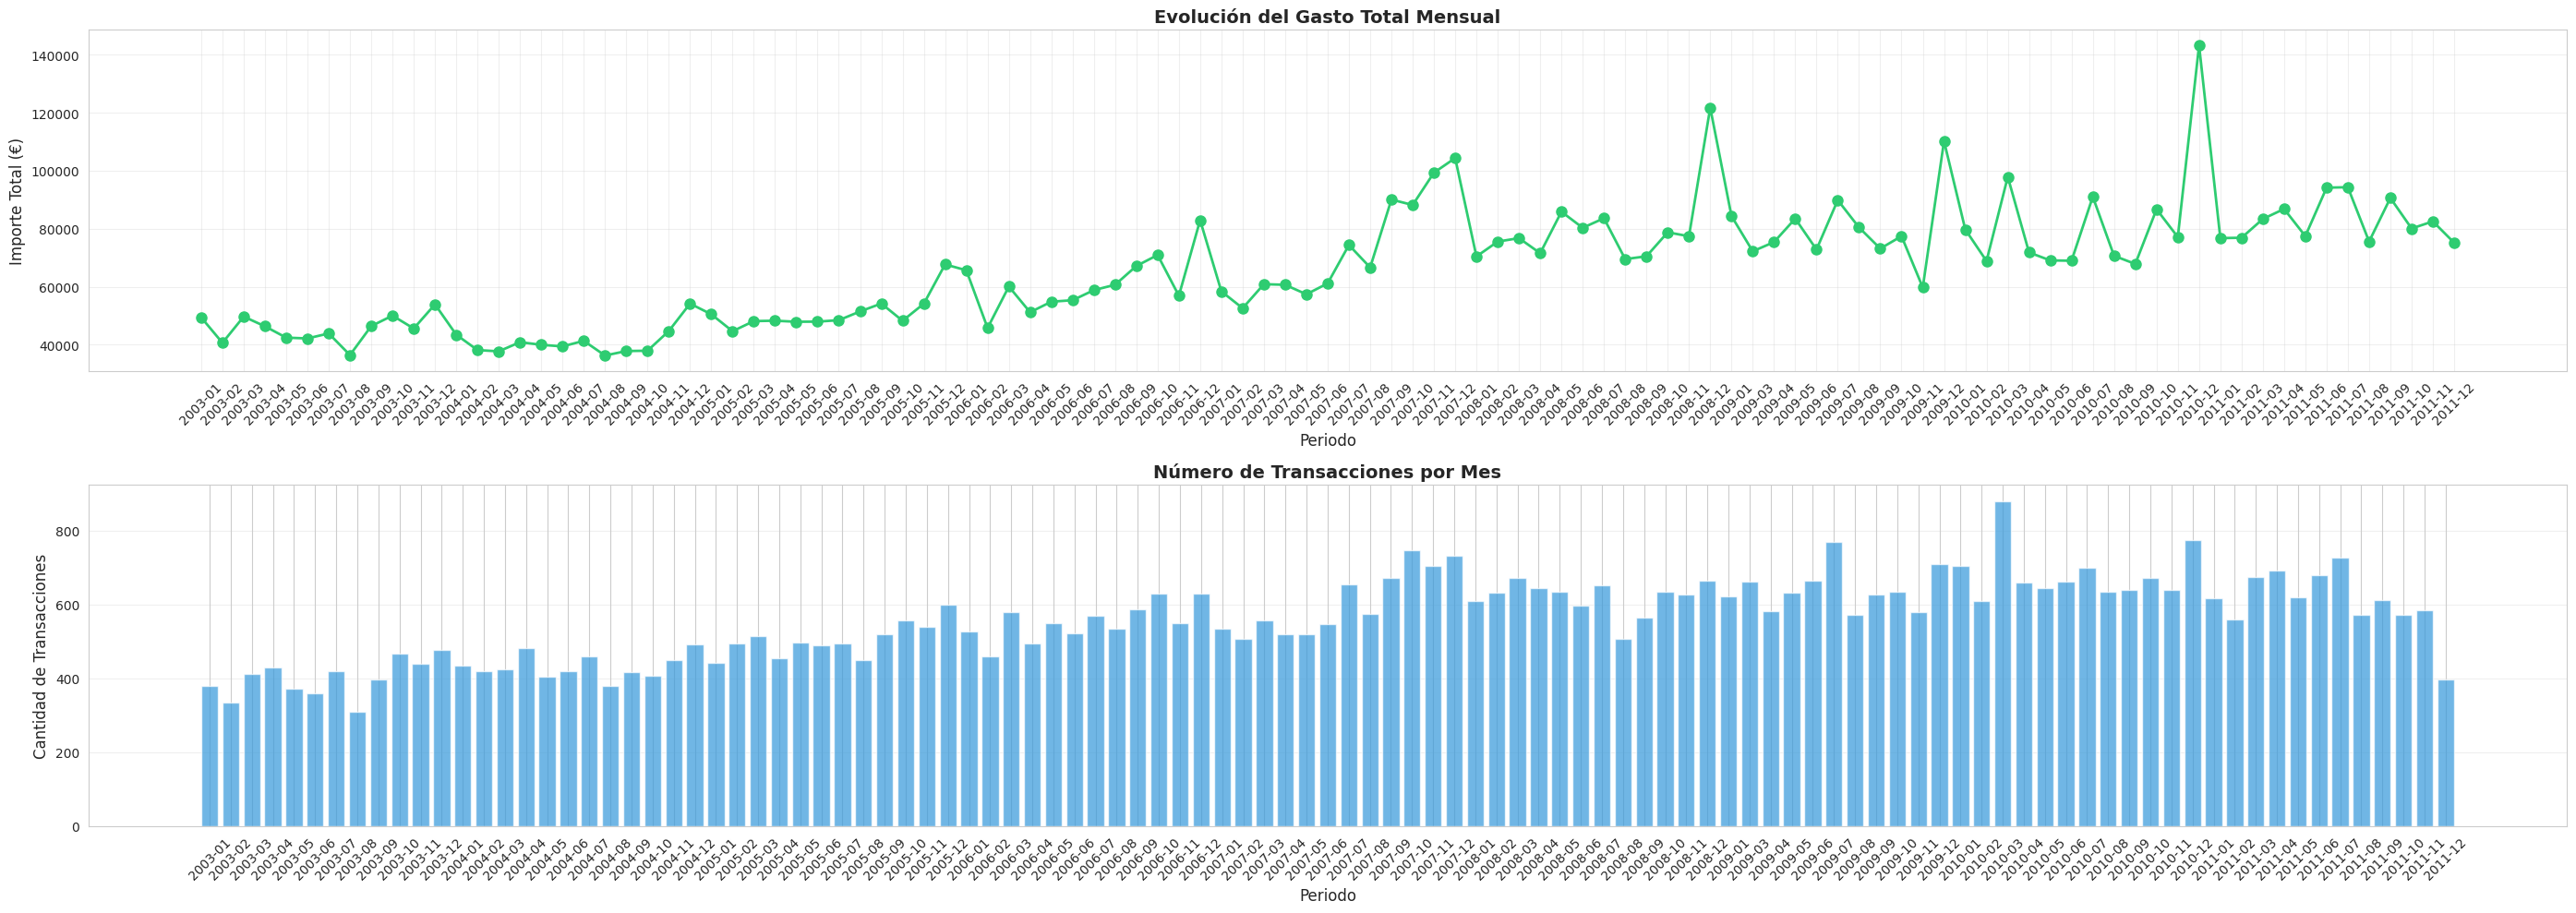

In [0]:
# GRÁFICO DE EVOLUCIÓN DE GASTOS MENSUALES

# Preparar datos
gastos_mensuales = df_desde_delta.filter(col("TIPO_TRANSACCION") == "GASTO") \
    .groupBy("AÑO", "MES") \
    .agg(
        count("*").alias("Transacciones"),
        sum("IMPORTE").alias("Total_Gastado")
    ) \
    .orderBy("AÑO", "MES") \
    .toPandas()

# Crear columna de fecha para el eje X
gastos_mensuales['Periodo'] = gastos_mensuales['AÑO'].astype(str) + '-' + gastos_mensuales['MES'].astype(str).str.zfill(2)

# Crear gráfico
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(28, 10))

# Gráfico 1: Total gastado
ax1.plot(gastos_mensuales['Periodo'], gastos_mensuales['Total_Gastado'], 
         marker='o', linewidth=2, markersize=8, color='#2ecc71')
ax1.set_title('Evolución del Gasto Total Mensual', fontsize=14, fontweight='bold')
ax1.set_xlabel('Periodo', fontsize=12)
ax1.set_ylabel('Importe Total (€)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Número de transacciones
ax2.bar(gastos_mensuales['Periodo'], gastos_mensuales['Transacciones'], 
        color='#3498db', alpha=0.7)
ax2.set_title('Número de Transacciones por Mes', fontsize=14, fontweight='bold')
ax2.set_xlabel('Periodo', fontsize=12)
ax2.set_ylabel('Cantidad de Transacciones', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Top Categorías de Comercio

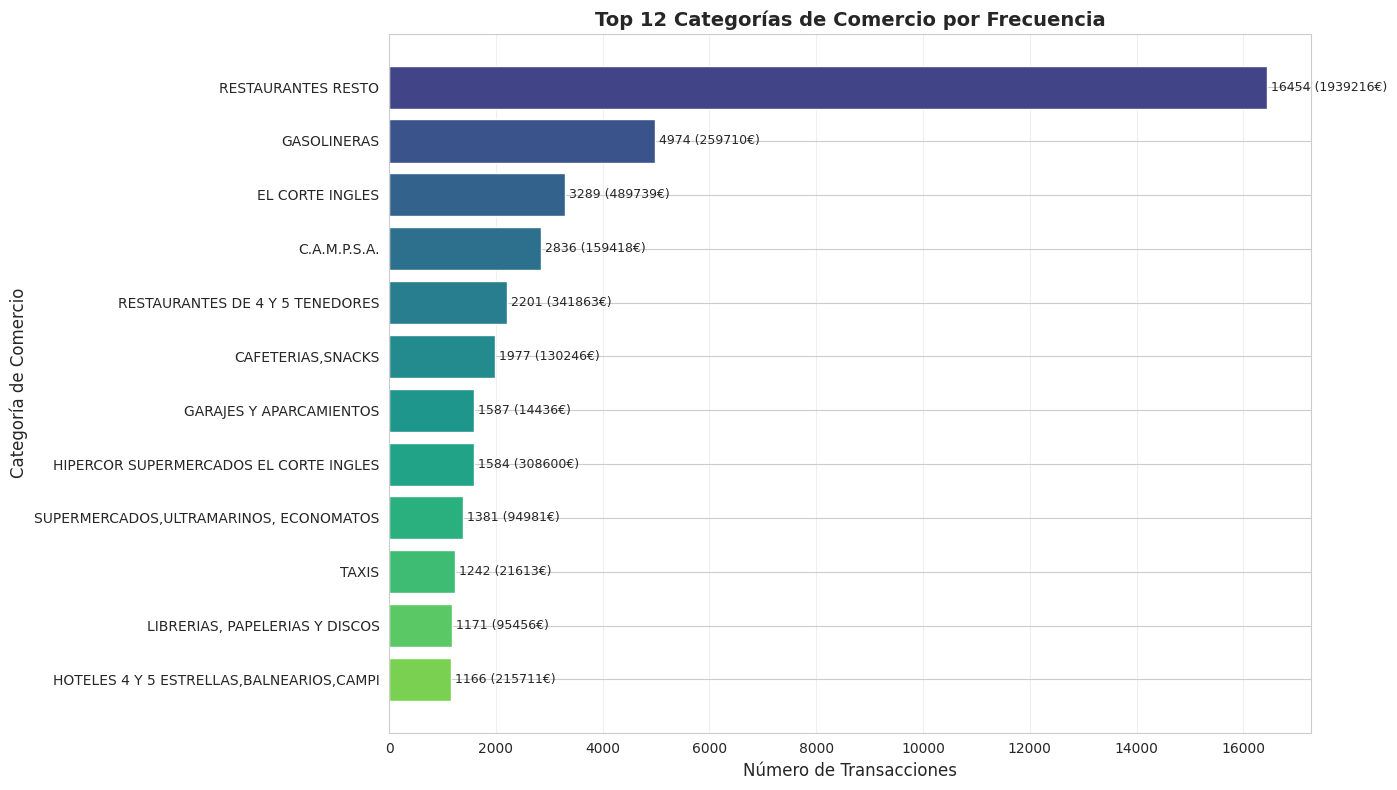

In [0]:
# GRÁFICO DE TOP CATEGORÍAS

# Preparar datos
top_categorias = df_desde_delta.filter(col("CATEGORIA_COMERCIO").isNotNull() &  (col("IMPORTE") > 0)) \
    .groupBy("CATEGORIA_COMERCIO") \
    .agg(
        count("*").alias("Transacciones"),
        sum("IMPORTE").alias("Total")
    ) \
    .orderBy(col("Transacciones").desc()) \
    .limit(12) \
    .toPandas()

# Crear gráfico
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(top_categorias['CATEGORIA_COMERCIO'], top_categorias['Transacciones'],
               color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top_categorias))))

ax.set_xlabel('Número de Transacciones', fontsize=12)
ax.set_ylabel('Categoría de Comercio', fontsize=12)
ax.set_title('Top 12 Categorías de Comercio por Frecuencia', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Añadir valores al final de cada barra
for i, (value, total) in enumerate(zip(top_categorias['Transacciones'], top_categorias['Total'])):
    ax.text(value, i, f' {value} ({total:.0f}€)', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Distribución por Tipo de Operación

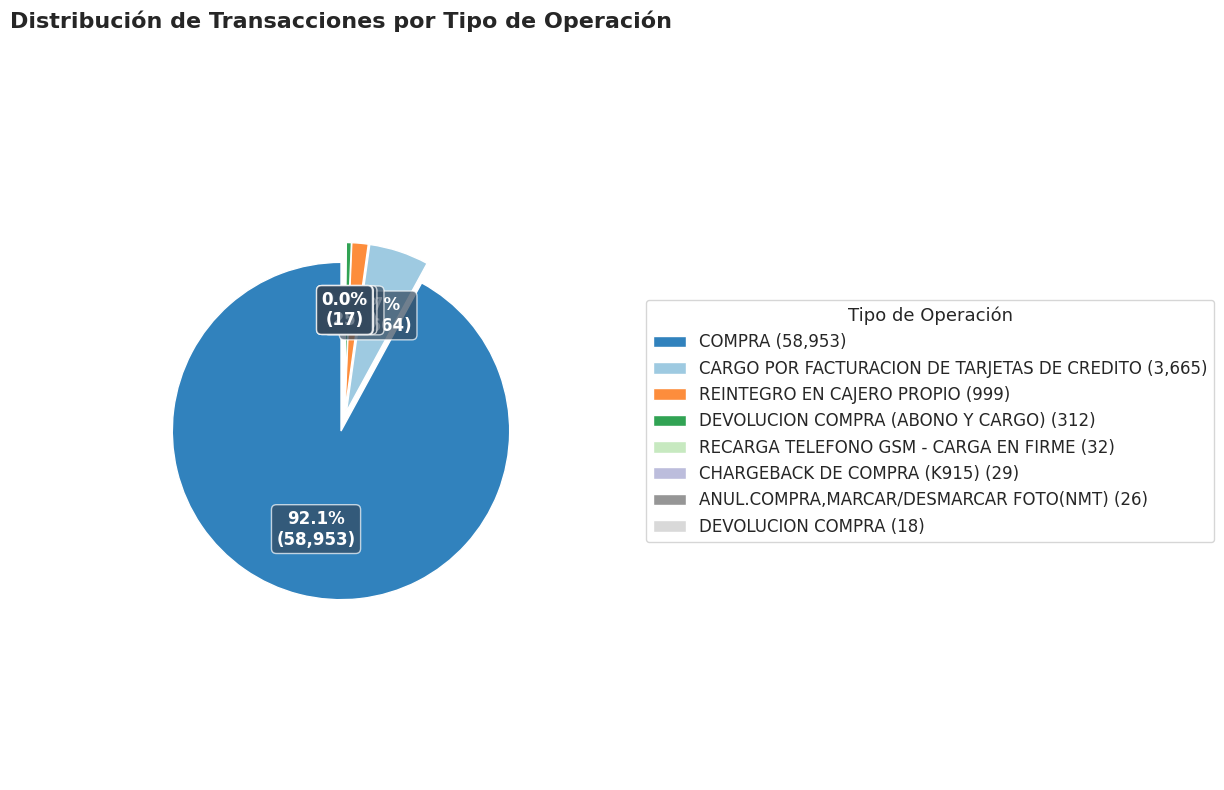

In [0]:
# GRÁFICO DE PASTEL: TIPOS DE OPERACIÓN

# Preparar datos
tipo_operacion = df_desde_delta.groupBy("COD_OPE_DESC") \
    .agg(count("*").alias("Total")) \
    .orderBy(col("Total").desc()) \
    .limit(8) \
    .toPandas()

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.tab20c(np.linspace(0, 1, len(tipo_operacion)))
explode = [0.08 if i == 0 else 0.04 for i in range(len(tipo_operacion))]

wedges, texts, autotexts = ax.pie(
    tipo_operacion['Total'],
    labels=None,  # No mostrar etiquetas en el gráfico
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*tipo_operacion["Total"].sum()):,})',
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_bbox(dict(facecolor='#34495e', alpha=0.7, boxstyle='round,pad=0.3'))

ax.set_title('Distribución de Transacciones por Tipo de Operación', 
             fontsize=16, fontweight='bold', pad=25)
ax.axis('equal')

# Crear leyenda aparte con los colores y nombres
legend_labels = [f'{desc} ({total:,})' for desc, total in zip(tipo_operacion['COD_OPE_DESC'], tipo_operacion['Total'])]
ax.legend(wedges, legend_labels, title="Tipo de Operación", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

### Patrones Horarios

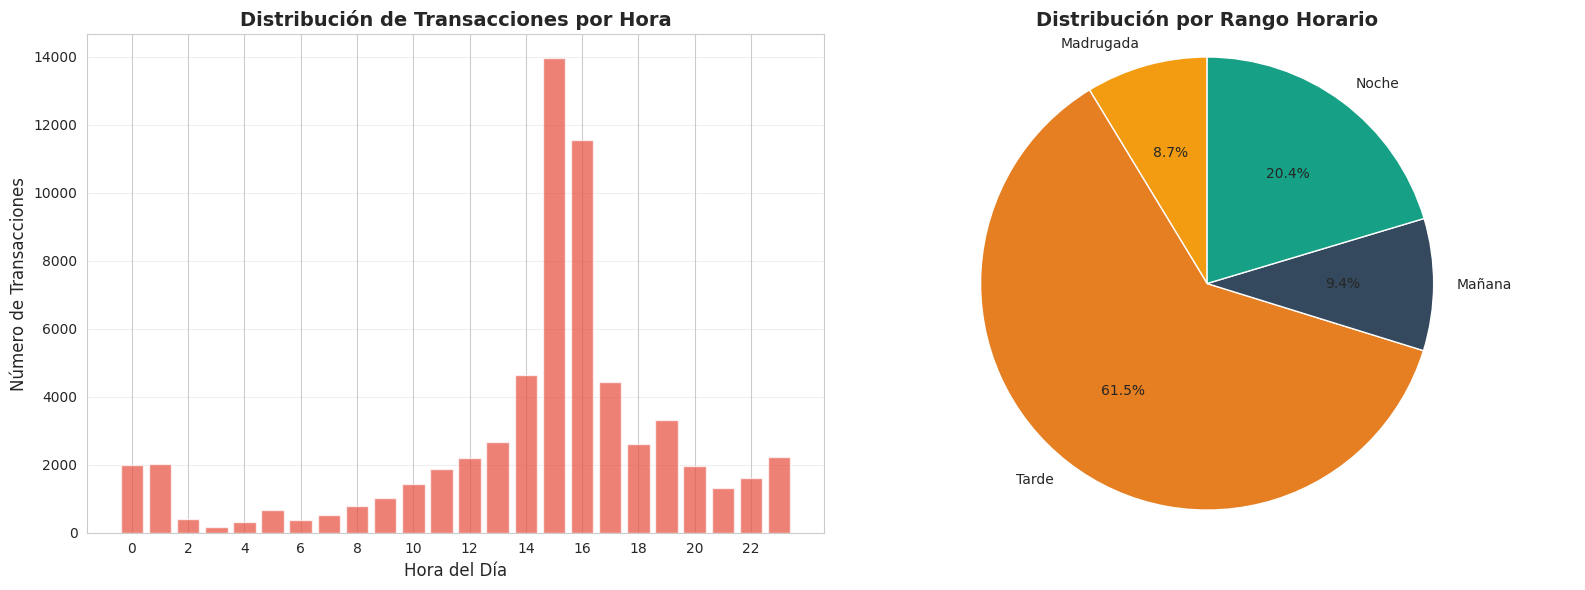

In [0]:

# GRÁFICO DE DISTRIBUCIÓN HORARIA

# Preparar datos por hora
distribucion_horaria = df_desde_delta.groupBy("HORA_NUMERO") \
    .agg(
        count("*").alias("Transacciones"),
        avg("IMPORTE_ABS").alias("Importe_Promedio")
    ) \
    .orderBy("HORA_NUMERO") \
    .toPandas()

# Crear gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Transacciones por hora
ax1.bar(distribucion_horaria['HORA_NUMERO'], 
        distribucion_horaria['Transacciones'],
        color='#e74c3c', alpha=0.7)
ax1.set_xlabel('Hora del Día', fontsize=12)
ax1.set_ylabel('Número de Transacciones', fontsize=12)
ax1.set_title('Distribución de Transacciones por Hora', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3, axis='y')

# Gráfico 2: Por rango horario
rango_horario = df_limpio.groupBy("RANGO_HORARIO") \
    .agg(count("*").alias("Total")) \
    .toPandas()

ax2.pie(rango_horario['Total'],
        labels=rango_horario['RANGO_HORARIO'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#f39c12', '#e67e22', '#34495e', '#16a085'])
ax2.set_title('Distribución por Rango Horario', fontsize=14, fontweight='bold')
ax2.axis('equal')

plt.tight_layout()
plt.show()

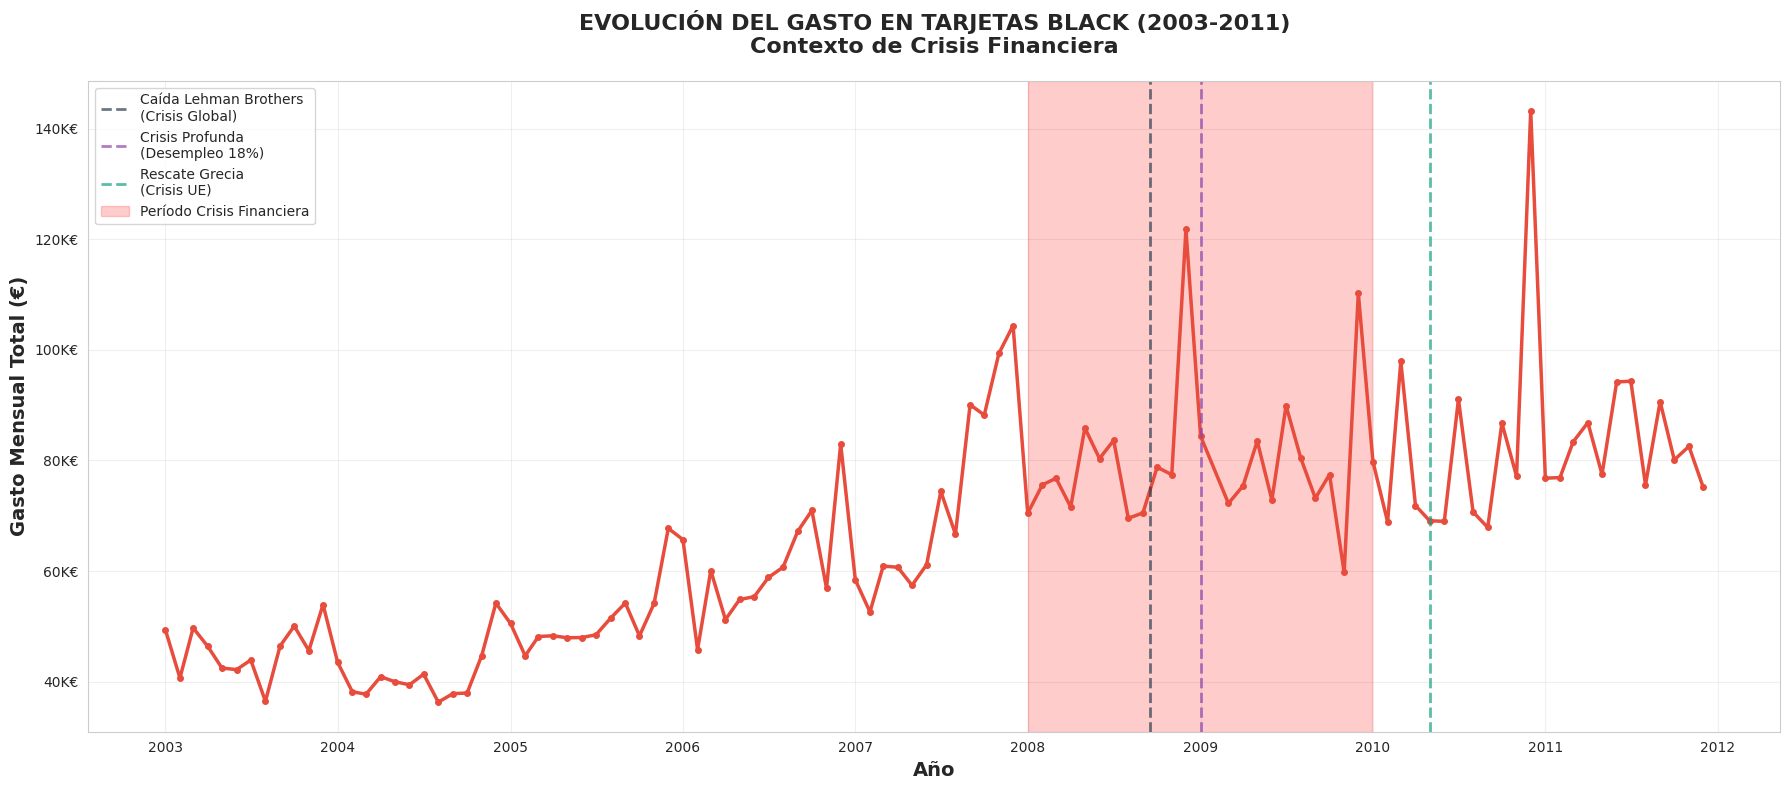


💡 ANÁLISIS:
El gráfico muestra cómo el gasto se mantuvo o AUMENTÓ durante la
crisis de 2008-2009, cuando millones de españoles sufrían las
consecuencias económicas más graves de la historia reciente.


In [0]:
# ═══════════════════════════════════════════════════════════════════════
# VISUALIZACIÓN: EVOLUCIÓN TEMPORAL CON EVENTOS HISTÓRICOS
# ═══════════════════════════════════════════════════════════════════════

# Preparar datos mensuales
timeline_data = df_desde_delta.filter(col("IMPORTE") > 0) \
    .groupBy("AÑO", "MES") \
    .agg(
        sum("IMPORTE").alias("Total_Gastado"),
        count("*").alias("Transacciones")
    ) \
    .orderBy("AÑO", "MES") \
    .toPandas()

# Crear fecha continua
timeline_data['Fecha'] = pd.to_datetime(
    timeline_data['AÑO'].astype(str) + '-' + 
    timeline_data['MES'].astype(str) + '-01'
)

# Crear visualización
fig, ax = plt.subplots(figsize=(18, 8))

# Gráfico de línea
ax.plot(timeline_data['Fecha'], timeline_data['Total_Gastado'], 
        linewidth=2.5, color='#e74c3c', marker='o', markersize=4)

# Marcar eventos históricos
eventos = [
    ('2008-09-15', 'Caída Lehman Brothers\n(Crisis Global)', '#2c3e50'),
    ('2009-01-01', 'Crisis Profunda\n(Desempleo 18%)', '#8e44ad'),
    ('2010-05-01', 'Rescate Grecia\n(Crisis UE)', '#16a085'),
    ('2012-01-01', 'Nacionalización Bankia', '#c0392b')
]

for fecha, texto, color in eventos:
    if pd.to_datetime(fecha) <= timeline_data['Fecha'].max():
        ax.axvline(pd.to_datetime(fecha), color=color, linestyle='--', 
                   linewidth=2, alpha=0.7, label=texto)

# Sombrear crisis
crisis_start = pd.to_datetime('2008-01-01')
crisis_end = pd.to_datetime('2009-12-31')
ax.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', 
           label='Período Crisis Financiera')

# Formato
ax.set_xlabel('Año', fontsize=14, fontweight='bold')
ax.set_ylabel('Gasto Mensual Total (€)', fontsize=14, fontweight='bold')
ax.set_title('EVOLUCIÓN DEL GASTO EN TARJETAS BLACK (2003-2011)\nContexto de Crisis Financiera', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K€'))

plt.tight_layout()
plt.show()

print("\n💡 ANÁLISIS:")
print("El gráfico muestra cómo el gasto se mantuvo o AUMENTÓ durante la")
print("crisis de 2008-2009, cuando millones de españoles sufrían las")
print("consecuencias económicas más graves de la historia reciente.")

---

## Referencias y Recursos Utilizados

### Dataset (Datos Publicos del caso "Tarjetas Black Caja Madrid")
- [Dataset Github](https://github.com/rafadelascuevas/limpieza-analisis-basico/tree/master/datasets/hoja_calculo_tarjetas_black/03_csv_para_limpiar)
- [Dataset Original y Noticia del caso](https://elpais.com/especiales/2014/tarjetas-opacas-caja-madrid/)

### Documentación Oficial:
- [Databricks Documentation](https://docs.databricks.com/)
- [Apache Spark Documentation](https://spark.apache.org/docs/latest/)
- [Delta Lake Documentation](https://docs.delta.io/)
- [PySpark API Reference](https://spark.apache.org/docs/latest/api/python/)

### Tutoriales y Guías:
- [Databricks Free Edition Setup](https://docs.databricks.com/getting-started/free-edition.html)
- [Spark SQL Guide](https://spark.apache.org/docs/latest/sql-programming-guide.html)
- [Delta Lake Quickstart](https://docs.delta.io/latest/quick-start.html)

### Herramientas Utilizadas:
- **Databricks Free Edition** - Plataforma de análisis
- **Apache Spark** - Motor de procesamiento
- **Delta Lake** - Capa de almacenamiento
- **Python** - Lenguaje de programación
- **Matplotlib/Seaborn** - Visualizaciones

---

- **Proyecto realizado por:** Carlos Saldeña, Brenda Silva, Luana Moya, Georgina Chavez. 
- **Curso:** Análisis de Datos en la Nube  
- **Institución:** ITU Universidad Nacional de Cuyo  
- **Fecha:** Noviembre 2025